# Chroma with MNIST

Chroma automatically selects the optimal set of data to label 

This notebook is an illustrative example of how to use Chroma with a simple iamge classifier, on the MNIST digits dataset.
We show how to prepare the model to extract the necessesary data, and all the core Chroma functionality. 

## Clone the Chroma repo, and install the Chroma python package

Not needed if you're running this notebook locally

In [ ]:
! git clone --branch main https://github.com/chroma-core/chroma.git
! cd chroma/ && python -m pip install --upgrade pip && pip install .
%cd chroma/examples

## Set up the model

We use a simple pre-trained digits classifier as our example model. The model was trained on 50% of the MNIST training set.

In [1]:
# Import what we need to create the model and dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

### Prepare the dataset

In [19]:
# We modify the MNIST Dataset class to expose some information about the source data
# to allow us to uniquely identify an input.
class CustomDataset(datasets.MNIST):
    def __getitem__(self, index):
        img, label = super().__getitem__(index) # Existing loader returns the img and the label
        resource_uri = f"{'train' if self.train else 't10k'}-images-idx3-ubyte-{index}"
        return img, label, resource_uri

In [20]:
# Normalizing transform for MNIST data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Get the MNIST training data (wrapped in our custom dataset)
train_mnist_data = CustomDataset("../data", train=True, transform=transform, download=True)

# Split the training data into equal 'training' and 'unlabeled' sets
train_size = len(train_mnist_data) // 2
unlabeled_size = len(train_mnist_data) - train_size
train_dataset, unlabeled_dataset = torch.utils.data.random_split(train_mnist_data, [train_size, unlabeled_size], generator=torch.Generator().manual_seed(42))


### Create and initialize the pretrained model

In [23]:
# A simple feed-forward CNN clasifier, with two conv. layers and two fully connected layers. 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        output = x.argmax(dim=1, keepdim=True)
        return output

In [24]:
# Set the device
device = 'cpu'

# Load up the pretrained model 
model = Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Prepare the model to extract [embeddings](https://docs.trychroma.com/concepts#extracting-model-embeddings)

In [25]:
# Create a forward hook class to extract and store embeddings from a supplied model layer
class EmbeddingHook:
  def __init__(self, module):
    self.hook = module.register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
    self.embeddings = output.detach().tolist()

  def __del__(self):
    self.hook.remove()

# Attach the embedding hook to the last fully connected layer before softmax
embedding_hook = EmbeddingHook(model.fc2)

## Use chroma

Chroma selects the best data to label among the data in the 'unlabeled' dataset, given the model and its training set.

In [47]:
# Import Chroma to our environment
from chroma import chroma
# Set up the Chroma client
chroma_client = chroma.get_api()

Running Chroma using direct local API.
Using DuckDB in-memory for database. Data will be transient.


### Send training data to Chroma

In [28]:
from tqdm.notebook import tqdm

# Send training data to Chroma
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

with torch.no_grad():
    for img, label, uri in tqdm(train_dataloader):
        inference_class = model(img)
        chroma_client.add_training(
            embedding=embedding_hook.embeddings,
            input_uri=list(uri),
            inference_class=inference_class.detach().flatten().tolist(),
            label_class=label.detach().tolist(),
        )

  0%|          | 0/469 [00:00<?, ?it/s]

### Send unlabeled data to Chroma

In [29]:
# Send unlabeled data to Chroma
unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=64)

with torch.no_grad():
    for img, label, uri in tqdm(unlabeled_dataloader):
        inference_class = model(img)
        chroma_client.add_unlabeled(
            embedding=embedding_hook.embeddings,
            input_uri=list(uri),
            inference_class=inference_class.detach().flatten().tolist(),
        )

  0%|          | 0/469 [00:00<?, ?it/s]

### Process the unseen data, and retrieve the results

By default, Chroma returns the best 1000 inputs to label. 

In [31]:
chroma_client.process()

time to fetch 30000 embeddings:  0.2687249183654785
time to fetch 30000 embeddings:  0.1871638298034668
time to fetch 30000 embeddings:  0.11549115180969238


True

In [33]:
results = chroma_client.get_results()

### Inspect the results

These are inputs in the unlabeled dataset which Chroma has recommended for labeling to optimally improve model performance.

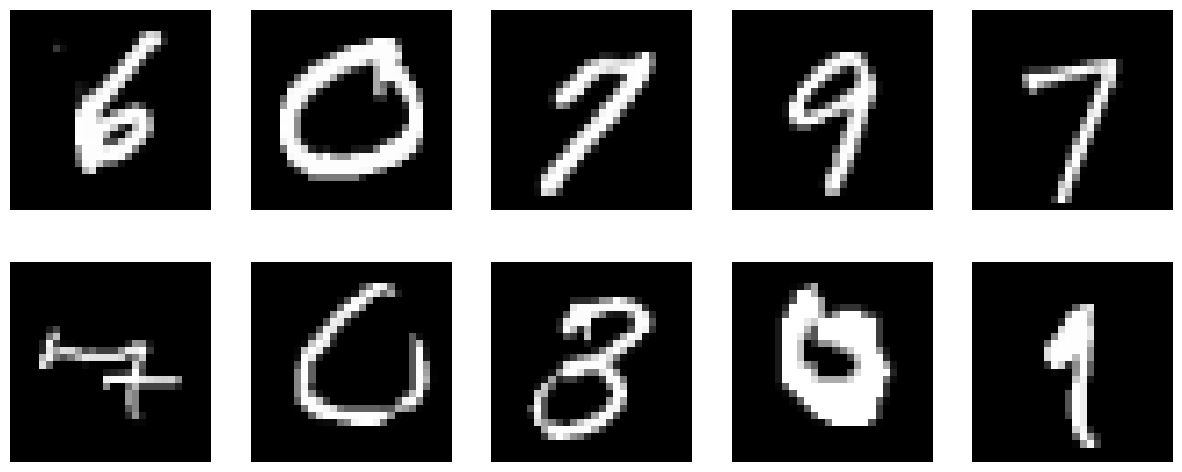

In [46]:
# Display some of the images chroma suggests to label
raw_data = datasets.mnist.read_image_file("../data/CustomDataset/raw/train-images-idx3-ubyte")

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = int(results[i].split("-")[-1])
    img = raw_data[index,:,:]          
    img = Image.fromarray(img.numpy(), mode="L")
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')